In [105]:
import numpy as np
import matplotlib.pyplot as plt
from hn2016_falwa.oopinterface import QGField
import xarray as xr
import os
import glob
import cartopy.crs as ccrs
from dask.distributed import Client, LocalCluster
import pandas as pd
from itertools import product
from cftime import DatetimeNoLeap
import seaborn as sns


In [2]:
cluster = LocalCluster(host='195.113.23.121')#, n_workers=4
client = Client(cluster) # 

In [3]:
client

Client Scheduler: tcp://195.113.23.121:33285 Dashboard: http://195.113.23.121:8787/status,Cluster Workers: 8 Cores: 64 Memory: 503.57 GiB


In [4]:
inpath = '/mnt/data02/model/CMAM/0A.daily/'

infile = os.path.join(inpath, 
                       f"QGFields_6hrlogH_CMAM_CMAM30-SD_r1i1p1_19790101-20101231.zarr")
print(infile)
#uref_xa.to_dataset().to_zarr(outfile, mode = "w-", consolidated=True)#.to_netcdf(outfile)

/mnt/data02/model/CMAM/0A.daily/QGFields_6hrlogH_CMAM_CMAM30-SD_r1i1p1_19790101-20101231.zarr


In [5]:
ds = xr.open_zarr(infile, consolidated=True)
ds

,Array,Chunk
Bytes,31.28 GiB,0.98 GiB
Shape,"(46720, 39, 48, 96)","(1460, 39, 48, 96)"
Count,33 Tasks,32 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,31.28 GiB,0.98 GiB
Shape,"(46720, 39, 48, 96)","(1460, 39, 48, 96)"
Count,33 Tasks,32 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


list of weak-vortex winters from [Nakamura et al 2020](https://journals.ametsoc.org/view/journals/atsc/77/3/jas-d-19-0249.1.xml)

In [6]:
month_ls = ds.time.dt.month
year_ls = ds.time.dt.year
weak_vortex_winter_ls = [1985, 1987, 1999, 2001, 2002, 2004, 2006, 2009, 2010, 2012, 2013]
mask = np.isin(month_ls, [1,2,3,4]) & np.isin(year_ls, weak_vortex_winter_ls)

In [15]:
np.isin(month_ls, [1,2,3,4])[:12]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [7]:
np.count_nonzero(mask)

4320

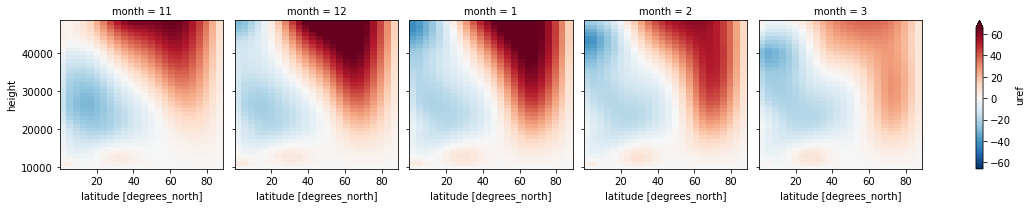

In [93]:
ds['uref'].sel(lat = slice(0,None)).groupby('time.month').mean('time').sel(month = [11,12,1,2,3]).plot(col = 'month',
                                                                                                       x = 'lat', robust = True)

In [8]:
ds_sel = ds.sel(time = mask)

In [9]:
sel_dict = dict(lat = 60, method = 'nearest')
uref_60 = ds_sel['uref'].sel(**sel_dict)
ratio = ds_sel['ua_int'].sel(**sel_dict).mean('lon')/uref_60
ratio

<xarray.DataArray (time: 4320, height: 39)>
dask.array<truediv, shape=(4320, 39), dtype=float32, chunksize=(480, 39), chunktype=numpy.ndarray>
Coordinates:
  * height   (height) int64 10000 11000 12000 13000 ... 45000 46000 47000 48000
    lat      float64 61.23
  * time     (time) object 1985-01-01 00:00:00 ... 2010-04-30 18:00:00

In [22]:
ration_tm = ratio.groupby('time.dayofyear').mean('time').load()

/home/kuchar/.conda/envs/moje/lib/python3.9/site-packages/xarray/plot/plot.py:932: UserWarning: The following kwargs were not used by contour: 'lw'
  primitive = ax.contour(x, y, z, **kwargs)


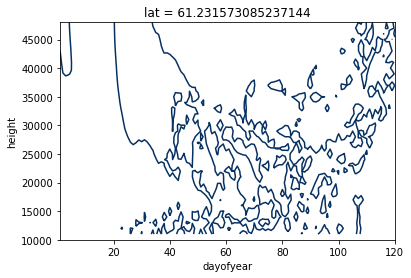

In [27]:
ration_tm.plot.contour(y = 'height', 
                       levels = [0.3], 
                       lw = 3 )

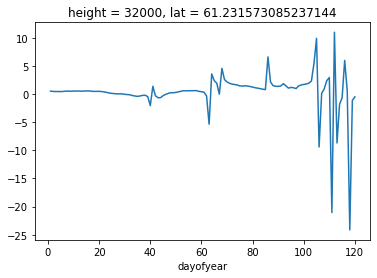

In [29]:
ratio.sel(height = 32_000).groupby('time.dayofyear').mean('time').plot()

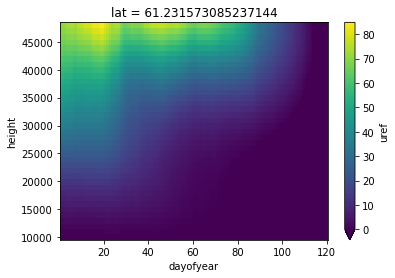

In [26]:
uref_60.groupby('time.dayofyear').mean('time').plot(y = 'height',
                                                   vmin = 0)

In [19]:
ration_tm = ratio.groupby('time.month').mean('time').load()

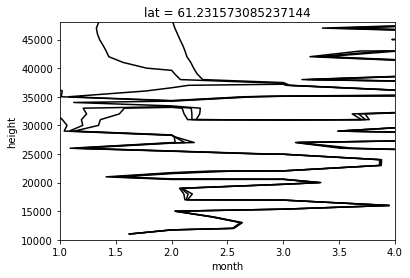

In [20]:
ration_tm.plot.contour(y = 'height', 
                       levels = [0.2,0.3,0.4], 
                       colors = 'k')

# SSWs

In [44]:
dates = ['1980-02-29', '1981-03-04',
         '1981-12-04', '1985-01-01',
         '1987-01-23', '1987-12-08',
         '1998-12-16', '2000-03-20',
         '2001-02-11', '2001-12-31',
         '2003-01-18', '2004-01-06',
         '2006-01-21', '2007-02-24',
         '2008-02-22', '2009-01-24',
         '2010-02-09']
dates = pd.to_datetime(dates)

In [82]:
sel_dict = dict(lat = 60, height = 32_000, method = 'nearest')
uref_60 = ds['uref'].sel(**sel_dict)
ratio = ds['ua_int'].sel(**sel_dict).mean('lon')/uref_60

max_lag = 30
lag_arr = range(-max_lag,max_lag+1)
ds_ls = []
for il, lag in enumerate(lag_arr):
    #print(lag)
    sel_dates = dates+pd.Timedelta(str(lag)+' days')
    sel_dates = sel_dates[~((sel_dates.month == 2) & (sel_dates.day == 29))]
    sel_dates = sel_dates[(sel_dates.year != 2011) & (sel_dates.year != 1978)]
    
    hourly_index_temp = [DatetimeNoLeap(*x, hour) for x, hour in product(zip(sel_dates.year, sel_dates.month, sel_dates.day), range(0,24,6))]
    comp_m = ratio.sel(time = hourly_index_temp).mean('time')
    comp_m.name = 'cmean'
    comp_s = ratio.sel(time = hourly_index_temp).std('time')
    comp_s.name = 'cstd'
    ds_ls.append(xr.merge([comp_m, comp_s]))
    
da_comp = xr.concat(ds_ls, dim = 'lag').load()
da_comp['lag'] = lag_arr
da_comp['lag'].attrs['units'] = 'day'
da_comp

<xarray.Dataset>
Dimensions:  (lag: 61)
Coordinates:
    height   int64 32000
    lat      float64 61.23
  * lag      (lag) int64 -30 -29 -28 -27 -26 -25 -24 ... 24 25 26 27 28 29 30
Data variables:
    cmean    (lag) float32 0.71 0.7191 0.7051 0.6947 ... 1.044 0.8553 0.8289
    cstd     (lag) float32 0.238 0.2428 0.2395 0.2398 ... 1.804 1.532 2.01 1.942

Given that the threshold is reached on average 4–5 days prior to an SSW event (Fig. 11 or below),  should provide a
forecast skill of SSW with a few days of lead time without a need for running a numerical weather prediction
model.

In [112]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 22})
plt.rc('text', usetex=False)

Text(0.5, 1.0, 'SSW composite at 32 km; 60°N in CMAM30')

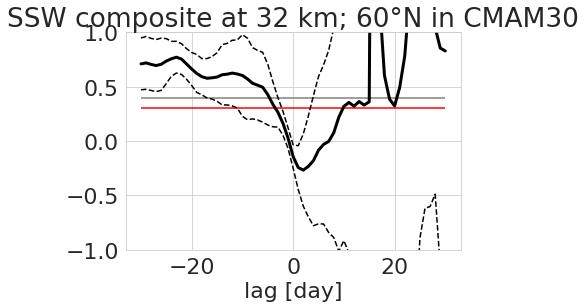

In [113]:
m = da_comp['cmean']
s = da_comp['cstd']
upper = m+s
lower = m-s
m.plot(lw = 3, color = 'k')
upper.plot(ls = 'dashed', color = 'k')
lower.plot(ls = 'dashed', color = 'k')
plt.ylim(-1,1)
plt.hlines(0.4,-max_lag, max_lag, color = 'gray')
plt.hlines(0.3,-max_lag, max_lag, color = 'red')
#plt.vlines(0,-1, 1, color = 'gray')
#plt.ylabel(r'$\bar{u}/u_{\mathrm{REF}}$')
#plt.grid(axis = 'x')
plt.title('SSW composite at 32 km; 60°N in CMAM30')

In [98]:
sel_dict = dict(lat = 60, method = 'nearest')
uref_60 = ds['uref'].sel(**sel_dict)
ratio = ds['ua_int'].sel(**sel_dict).mean('lon')/uref_60
ratio.name = 'ratio'
ratio

<xarray.DataArray 'ratio' (time: 46720, height: 39)>
dask.array<truediv, shape=(46720, 39), dtype=float32, chunksize=(1460, 39), chunktype=numpy.ndarray>
Coordinates:
  * height   (height) int64 10000 11000 12000 13000 ... 45000 46000 47000 48000
    lat      float64 61.23
  * time     (time) object 1979-01-01 00:00:00 ... 2010-12-31 18:00:00

In [99]:
ratio.nbytes/1e6

7.28832

In [100]:
inpath = '/mnt/data02/model/CMAM/0A.daily/'
outfile = os.path.join(inpath, 
                       f"ratio_6hrlogH_CMAM_CMAM30-SD_r1i1p1_19790101-20101231.nc")
ratio.to_netcdf(outfile)

In [102]:
inpath = '/mnt/data02/model/CMAM/0A.daily/'
outfile = os.path.join(inpath, 
                       f"ratio_DailylogH_CMAM_CMAM30-SD_r1i1p1_19790101-20101231.nc")
ratio.resample(time = '1D').mean().to_netcdf(outfile)